In [3]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import time
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.size'] = 10
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times New Roman']

from canon.pattern.model import GMModel, KMeansModel, BGMModel, MeanShiftModel
from canon.seq.seqreader import SeqReader
from canon.pattern.labeler import SeqLabeler

np.random.seed(4)

def read_seq(seq, key="orsnr___"):
    seqfile = os.path.join("seq", seq+".SEQ")
    reader = SeqReader(seqfile)    
    Z = reader.get_Zmap(key)[0]
    return Z[::-1, :]

def fill_features(features, img_shape):
    num_points = np.prod(img_shape)
    if len(features) != num_points:
        print("Filling %d features to %d data points" % (len(features), num_points))
        features2 = np.zeros((np.prod(img_shape), features.shape[1] - 1))
        features2[features[:, 0].astype('int') - 1] = features[:, 1:]
        return features2
    else:
        return features[:, 1:]
    
def xy_to_idx(x, y, img_shape):
    return y * img_shape[1] + x

def idx_to_xy(idx, img_shape, flip_vertical=True):
    x = int(idx / img_shape[1])
    y = idx % img_shape[1]
    if flip_vertical:
        x = img_shape[0] - x - 1
    return y, x

Using TensorFlow backend.


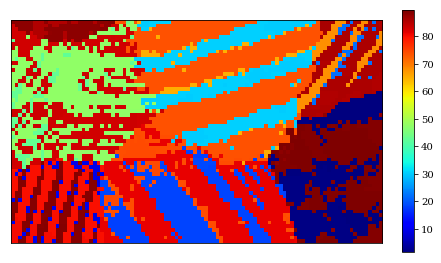

In [2]:
seq = "BTO_25C_wb3_"
Z = read_seq(seq)
vmax, vmin = Z.max(), Z.min()
plt.imshow(Z, cmap='jet', aspect=1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.tight_layout()
plt.colorbar(fraction=0.03)
plt.savefig("img/BTO_SEQ.pdf", bbox_inches='tight', dpi=300)

Silhouette Score = 0.20714635496371647, Calinski-Harabaz Score = 1742.4855926854216


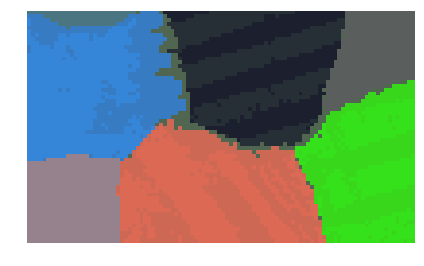

In [3]:
feature_file = "BTO_25C_wb3_60_100_256"
img_shape = (60, 100)

features = np.load("features/" + feature_file + ".npy")
features = fill_features(features, img_shape)

model = KMeansModel()
pca = PCA(n_components=10)
scaler = StandardScaler()
model.train(features, n_clusters=12, preprocessors=[])

silhouette = model.compute_silhouette_score(features)
calinski = model.compute_calinski_harabaz_score(features)
print("Silhouette Score = {}, Calinski-Harabaz Score = {}".format(silhouette, calinski))

scores = np.array(model.score(features))
Z = model.color_by_pca(scores.reshape(img_shape))

fig, ax = plt.subplots(ncols=1, nrows=1)
ax.imshow(Z[::-1, :, :], aspect=1)
ax.axis('off')
plt.tight_layout()
# fig.savefig("img/Z.pdf", bbox_inches='tight', figsize=(5, 4), dpi=300)

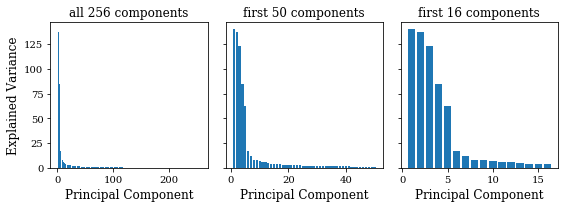

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 

pca = PCA()
pftrs = pca.fit_transform(features)

n_components = pca.components_.shape[0]

fig, ax = plt.subplots(1, 3, figsize=(8, 3), sharey='all')
X = np.arange(1, n_components+1)
Y = pca.explained_variance_ 
ax[0].bar(X, Y)
ax[0].set_title(r'all 256 components', fontsize=12)
# ax[0].text(0.55, 0.9, r'256 components', fontsize=12, transform=ax[0].transAxes)
ax[1].bar(X[:50], Y[:50])
ax[1].set_title(r'first 50 components', fontsize=12)
ax[2].bar(X[:16], Y[:16])
ax[2].set_title(r'first 16 components', fontsize=12)
ax[0].set_ylabel('Explained Variance', fontsize=12)
ax[0].set_xlabel('Principal Component', fontsize=12)
ax[1].set_xlabel('Principal Component', fontsize=12)
ax[2].set_xlabel('Principal Component', fontsize=12)
plt.tight_layout()
fig.savefig("img/pca.pdf", dpi=300)

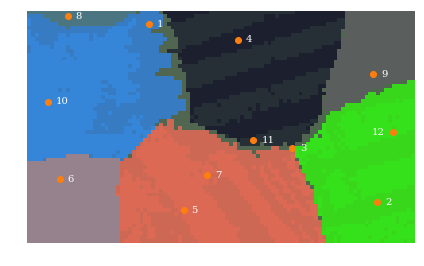

In [5]:
delegates = model.delegates(features)
pts = np.array([idx_to_xy(delegate, img_shape) for delegate in delegates]).astype('int32')
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.imshow(Z[::-1, :, :], aspect=1)
ax.scatter(pts[:,0], pts[:,1], color='tab:orange', clip_on=False)
for i, pt in enumerate(pts):
    x, y = pt[0], pt[1]
    ha, va = 'left', 'center'
    if pt[1] > 0.9*img_shape[0]:
        ha, va = 'center', 'bottom'
        y = y - 2
    elif pt[0] > 0.9*img_shape[1]:
        ha = 'right'
        x = x - 2        
    else:
        x = x + 2    
    ax.text(x, y, '%d' % (i + 1), color='w', ha=ha, va=va)
ax.axis('off')
plt.tight_layout()

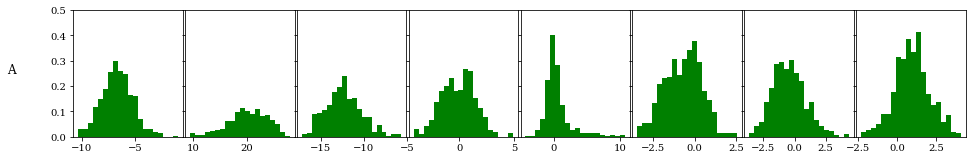

In [76]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

def component_analyze(cluster, title='A', ax=None):
    cftrs = pftrs[np.where(scores == cluster)[0]]
    
    nrows = 1
    ncols = 8
    if ax is None:
        fig, ax = plt.subplots(nrows, ncols, figsize=(2*ncols, 2*nrows), sharey='row')
        fig.subplots_adjust(bottom=0, wspace=0.02, hspace=0.02)
    paxs = cftrs.std(axis=0).argsort()[-ncols*nrows:]
    for i in range(nrows):
        for j in range(ncols):        
            pax = i*ncols + j
            if ncols == 1 or nrows == 1:
                ax0 = ax[i*ncols + j]
            else:
                ax0 = ax[i][j]
            n, bins, patches = ax0.hist(cftrs[:, pax], 20, density=True, facecolor='green')
            # ax0.set_title(pax)
            ax0.set_ylim([0, 0.5])
            # ax0.set_xlim([pftrs[:, pax].min(), pftrs[:, pax].max()])
            # ax0.set_xlim([pftrs.min(), pftrs.max()])
    ax[0].text(-0.6, 0.5, title, fontsize=12, transform=ax[0].transAxes)
            
component_analyze(1)

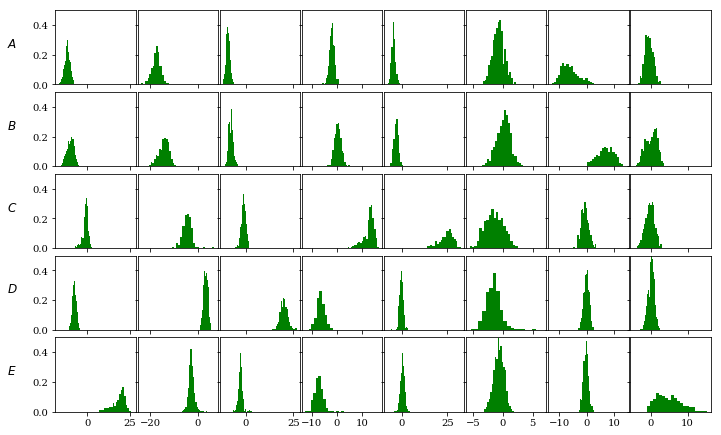

In [81]:
fig, axes = plt.subplots(5, 8, figsize=(10, 6), sharey='row', sharex='col')
fig.subplots_adjust(top=0.98, bottom=0.05, right=0.99, left=0.08, wspace=0.02, hspace=0.1)
component_analyze(3, title="$A$", ax=axes[0, :])
component_analyze(10, title="$B$", ax=axes[1, :])
component_analyze(8, title="$C$", ax=axes[2, :])
component_analyze(9, title="$D$", ax=axes[3, :])
component_analyze(6, title="$E$", ax=axes[4, :])
fig.savefig("img/distribution.pdf", dpi=300)

NX: 100 x NY: 60    step size: 5 x 5


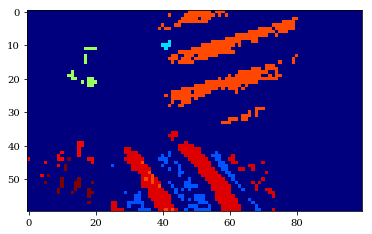

In [23]:
seq = "BTO_25C_wb3_"
Z = read_seq(seq, nidx_thres=80)
plt.imshow(Z, cmap='jet')

In [18]:
np.where(np.isnan(Z))

(array([], dtype=int64), array([], dtype=int64))

In [12]:
from itertools import combinations
from scipy.stats import kendalltau

def topo_disorder(a, b, dist):
    if len(a) != len(b):
        raise ValueError("a and b must be of the same length")
    if not isinstance(a, np.ndarray):
        a = np.array(a)
    if not isinstance(b, np.ndarray):
        b = np.array(b)
    pairs = np.array(list(combinations(range(len(a)), 2)))
    d1 = dist(a[pairs])
    d2 = dist(b[pairs])
    t, _ =  kendalltau(d1, d2)
    return (1 - t) / 2

topo_disorder(np.array([1, 2, 3]), np.array([3, 5, 4]), lambda A: A[:, 0] - A[:, 1])

[[0 1]
 [0 2]
 [1 2]]


0.5

In [14]:
import math
from scipy.misc import comb
def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)


comb(len(features), 2)

NameError: name 'features' is not defined